In [1]:
import os
import pandas as pd
from datetime import datetime

# پوشه داده‌ها
data_folder = 'lake_data_35Day'
lake_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.txt')]

all_lakes = []

for file in lake_files:
    with open(file, encoding='utf-8') as f:
        lines = f.readlines()
    
    # --- استخراج متادیتا ---
    lake_id = None
    lake_name = None
    latitude = None
    longitude = None
    for i, line in enumerate(lines):
        if i == 1:  # شناسه و نام (مثال: "000004 Edward              : Target database id number and name")
            tokens = line.split(':')[0].strip().split()
            if len(tokens) >= 2:
                lake_id = tokens[0]
                lake_name = ' '.join(tokens[1:])
        if i == 2:  # مختصات (مثال: "  -0.389   29.540          : Latitude and longitude ...")
            tokens = line.split(':')[0].strip().split()
            if len(tokens) >= 2:
                latitude = float(tokens[0])
                longitude = float(tokens[1])
                if longitude > 180:
                    longitude -= 360
        if i > 15:  # فرض می‌کنیم متادیتا تا اینجا هست
            break

    # --- استخراج داده عددی ---
    data_rows = []
    for line in lines:
        tokens = line.strip().split()
        # شرط: حداقل 15 ستون و ستون سوم تاریخ 8 رقمی (YYYYMMDD)
        if len(tokens) >= 15 and tokens[2].isdigit() and len(tokens[2]) == 8:
            try:
                row = {
                    'satellite': tokens[0],           # نام ماهواره (S3A, SENT6, ...)
                    'pass_no': int(tokens[1]),        # شماره پاس
                    'date': datetime.strptime(tokens[2], '%Y%m%d'),  # تاریخ
                    'cycle': int(tokens[3]),          # سیکل
                    'day': int(tokens[4]),            # روز
                    'obs_height': float(tokens[5]),  # ارتفاع مشاهده شده
                    'err': float(tokens[6]),          # خطا
                    'temp': float(tokens[7]),         # دما یا پارامتر مربوطه
                    'method1': tokens[8],             # متد اول (مثلاً ECM)
                    'method2': tokens[9],             # متد دوم (مثلاً GIM)
                    'method3': tokens[10],            # متد سوم (مثلاً ECM)
                    'param1': int(tokens[11]),        # پارامتر 1 (مثلاً 1)
                    'param2': int(tokens[12]),        # پارامتر 2
                    'param3': int(tokens[13]),        # پارامتر 3
                    'height_egm2008': float(tokens[14]), # ارتفاع اصلاح شده EGM2008
                    'extra': float(tokens[15]) if len(tokens) > 15 and tokens[15].replace('.', '', 1).replace('-', '', 1).isdigit() else None
                }
                data_rows.append(row)
            except Exception as e:
                # اگر خطایی در تبدیل عددی بود ردش کن
                continue

    # ساختار نهایی هر دریاچه
    lake_struct = {
        'lake_id': lake_id,
        'lake_name': lake_name,
        'latitude': latitude,
        'longitude': longitude,
        'data': data_rows
    }
    all_lakes.append(lake_struct)

# تبدیل لیست به DataFrame
df_lakes = pd.DataFrame(all_lakes)

# نمایش نمونه
print(f"تعداد دریاچه‌ها: {len(df_lakes)}")
print(df_lakes.iloc[0]['lake_name'])
if df_lakes.iloc[0]['data']:
    print(df_lakes.iloc[0]['data'][0])

# ذخیره در پیکل
df_lakes.to_pickle('lake_struct_data.pkl')
print('داده‌ها استخراج و ذخیره شدند.')


تعداد دریاچه‌ها: 45
Cardiel
{'satellite': 'ENVI', 'pass_no': 6, 'date': datetime.datetime(2002, 5, 16, 0, 0), 'cycle': 3, 'day': 24, 'obs_height': 999.99, 'err': 99.999, 'temp': 999.99, 'method1': 'N/A', 'method2': 'N/A', 'method3': 'N/A', 'param1': 9, 'param2': 9, 'param3': 0, 'height_egm2008': 9999.99, 'extra': 0.0}
داده‌ها استخراج و ذخیره شدند.


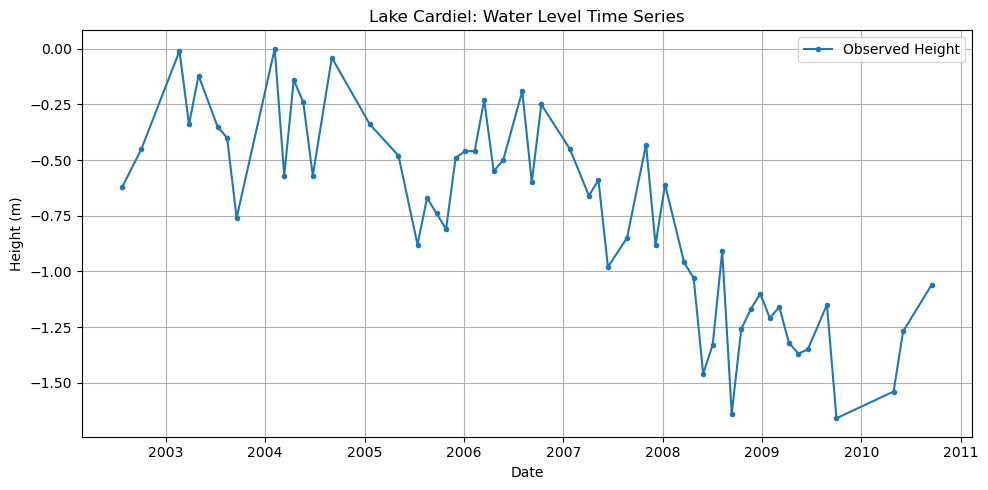

In [3]:
import matplotlib.pyplot as plt

# فرض: df_lakes قبلاً بارگذاری شده و آماده است
talbot = df_lakes[df_lakes['lake_name'] == 'Cardiel'].iloc[0]
data = talbot['data']

# استخراج تاریخ و ارتفاع، فقط مقادیر معتبر
times = [row['date'] for row in data if row['obs_height'] < 900]
heights = [row['obs_height'] for row in data if row['obs_height'] < 900]

plt.figure(figsize=(10,5))
plt.plot(times, heights, marker='.', linestyle='-', label='Observed Height')
plt.xlabel('Date')
plt.ylabel('Height (m)')
plt.title('Lake Cardiel: Water Level Time Series')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
